In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [2]:
from fastai.vision.all import *
from fastcore.parallel import *

In [3]:
!kaggle competitions download -c paddy-disease-classification

100% 1.02G/1.02G [00:07<00:00, 58.7MB/s]
100% 1.02G/1.02G [00:07<00:00, 137MB/s] 


In [4]:
!unzip -q paddy-disease-classification

In [5]:
Path.BASE_PATH = path = Path()
trn_path = path/'train_images'
path.ls()

(#7) [Path('.config'),Path('train.csv'),Path('test_images'),Path('train_images'),Path('sample_submission.csv'),Path('paddy-disease-classification.zip'),Path('sample_data')]

In [6]:
im_files = get_image_files(trn_path)
im_files

(#10407) [Path('train_images/downy_mildew/107356.jpg'),Path('train_images/downy_mildew/109143.jpg'),Path('train_images/downy_mildew/103994.jpg'),Path('train_images/downy_mildew/101548.jpg'),Path('train_images/downy_mildew/109719.jpg'),Path('train_images/downy_mildew/103940.jpg'),Path('train_images/downy_mildew/106305.jpg'),Path('train_images/downy_mildew/106759.jpg'),Path('train_images/downy_mildew/103850.jpg'),Path('train_images/downy_mildew/106254.jpg')...]

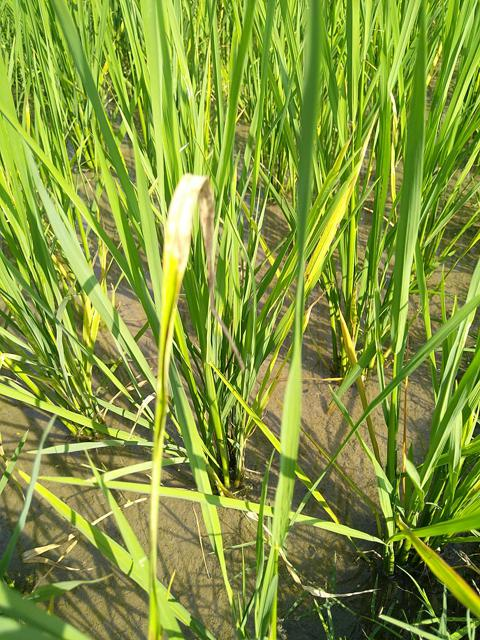

In [7]:
im = PILImage.create(im_files[0])
im

In [8]:
doc(aug_transforms)

aug_transforms(mult: 'float' = 1.0, do_flip: 'bool' = True, flip_vert: 'bool' = False, max_rotate: 'float' = 10.0, min_zoom: 'float' = 1.0, max_zoom: 'float' = 1.1, max_lighting: 'float' = 0.2, max_warp: 'float' = 0.2, p_affine: 'float' = 0.75, p_lighting: 'float' = 0.75, xtra_tfms: 'list' = None, size: 'int | tuple' = None, mode: 'str' = 'bilinear', pad_mode='reflection', align_corners=True, batch=False, min_scale=1.0)
Utility func to easily create a list of flip, rotate, zoom, warp, lighting transforms.

To get a prettier result with hyperlinks to source code and documentation, install nbdev: pip install nbdev


In [9]:
dls = ImageDataLoaders.from_folder(trn_path,
                                   valid_pct=0.2,
                                   item_tfms=Resize(480),
                                   batch_tfms=[*aug_transforms(size=224, min_scale=0.2 ), Normalize.from_stats(*imagenet_stats)])

In [10]:
learner = vision_learner(dls, resnet50, metrics=error_rate).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 122MB/s]


In [11]:
learner.fine_tune(12)

epoch,train_loss,valid_loss,error_rate,time
0,2.050484,1.282890,0.412782,01:14


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch,train_loss,valid_loss,error_rate,time
0,1.380930,0.974450,0.320038,01:16
1,1.104675,0.756527,0.255646,01:18
2,0.890168,0.634211,0.219125,01:18
3,0.696196,0.445518,0.148486,01:18
4,0.564269,0.361427,0.115329,01:16
5,0.470765,0.350144,0.109082,01:16
6,0.403107,0.246344,0.078808,01:17
7,0.362736,0.240492,0.074964,01:16
8,0.292444,0.211712,0.062951,01:18
9,0.279756,0.220716,0.070639,01:17


In [12]:
tst_img = get_image_files(path/'test_images')
tst_img

(#3469) [Path('test_images/202430.jpg'),Path('test_images/203355.jpg'),Path('test_images/202029.jpg'),Path('test_images/202800.jpg'),Path('test_images/200724.jpg'),Path('test_images/200265.jpg'),Path('test_images/202167.jpg'),Path('test_images/202165.jpg'),Path('test_images/200001.jpg'),Path('test_images/200713.jpg')...]

In [13]:
tst_img.sort()

In [14]:
tst_img

(#3469) [Path('test_images/200001.jpg'),Path('test_images/200002.jpg'),Path('test_images/200003.jpg'),Path('test_images/200004.jpg'),Path('test_images/200005.jpg'),Path('test_images/200006.jpg'),Path('test_images/200007.jpg'),Path('test_images/200008.jpg'),Path('test_images/200009.jpg'),Path('test_images/200010.jpg')...]

In [15]:
test_dl = dls.test_dl(tst_img)

In [16]:
preds,targs = learner.tta(dl=test_dl)

In [21]:
preds.shape, preds.argmax(dim=1).shape

(torch.Size([3469, 10]), torch.Size([3469]))

In [27]:
dls.c, dls.vocab

(10,
 ['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro'])

In [30]:
labels = dls.vocab[preds.argmax(dim=1)]
labels

(#3469) ['hispa','normal','brown_spot','blast','blast','brown_spot','dead_heart','brown_spot','hispa','normal'...]

In [31]:
idxs = pd.Series(labels, name="idxs")

In [32]:
idxs

0                       hispa
1                      normal
2                  brown_spot
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Name: idxs, Length: 3469, dtype: object

In [33]:
mapping =  enumerate(dls.vocab)
mapping

In [36]:
sdf = pd.read_csv('sample_submission.csv')
sdf.head()

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN


In [37]:
sdf['label'] = idxs

In [38]:
sdf

,image_id,label
0,200001.jpg,hispa
1,200002.jpg,normal
2,200003.jpg,brown_spot
3,200004.jpg,blast
4,200005.jpg,blast
...,...,...
3464,203465.jpg,dead_heart
3465,203466.jpg,hispa
3466,203467.jpg,normal
3467,203468.jpg,bacterial_leaf_streak


In [ ]:
sdf

,image_id,label
0,200001.jpg,hispa
1,200002.jpg,normal
2,200003.jpg,downy_mildew
3,200004.jpg,blast
4,200005.jpg,blast
...,...,...
3464,203465.jpg,dead_heart
3465,203466.jpg,hispa
3466,203467.jpg,normal
3467,203468.jpg,bacterial_leaf_streak


In [39]:
sdf.to_csv('subm.csv', index=False )

In [40]:
!cat subm.csv | head

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,brown_spot
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


In [41]:
!kaggle competitions submit -h

usage: kaggle competitions submit [-h] -f FILE_NAME -m MESSAGE [-q] [competition]

required arguments:
  -f FILE_NAME, --file FILE_NAME
                        File for upload (full path)
  -m MESSAGE, --message MESSAGE
                        Message describing this submission

options:
  -h, --help            show this help message and exit
  competition           Competition URL suffix (use "kaggle competitions list" to show options)
                        If empty, the default competition will be used (use "kaggle config set competition")"
  -q, --quiet           Suppress printing information about the upload/download progress


In [42]:
!kaggle competitions submit -f subm.csv -m "resnet50 12epoch with norm and aug transform " paddy-disease-classification

100% 70.4k/70.4k [00:00<00:00, 140kB/s]
Successfully submitted to Paddy Doctor: Paddy Disease Classification